In [ ]:
using MAT, Plots, MIRT, LinearAlgebra, Random, JLD
include("algorithms.jl")
include("MRI_operators.jl");

# 4. PINCAT phantom example
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_PINCAT_phantom.m

## 4.1 Preparation

**Read data**

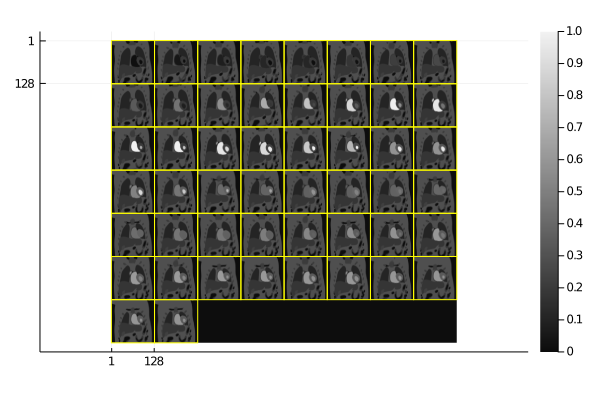

In [2]:
data = matread("../reproduce-l-s-dynamic-mri/data/aperiodic_pincat.mat")["new"]
X_orig = permutedims(data, [2, 1, 3]) ./ maximum(data)
nx,ny,nt = size(X_orig);
jim(X_orig)

**Simulate coil maps**

`ir_mri_sensemap_sim` is part of MIRT.jl
 - https://github.com/JeffFessler/MIRT.jl/blob/master/src/mri/sensemap-sim.jl

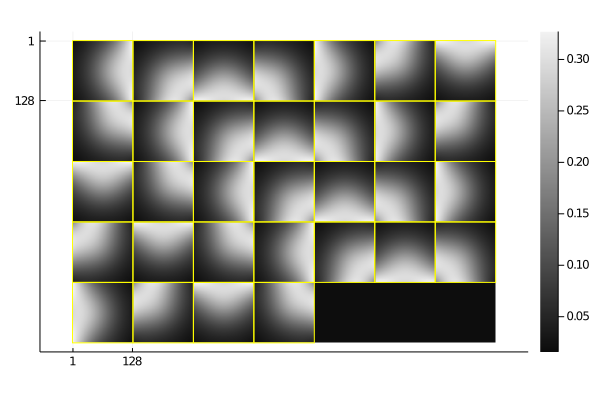

In [3]:
nc = 8;
nring = 4;
b1,_ = ir_mri_sensemap_sim(dims=(nx,ny), dx=1.5, dz=1.5,
    ncoil=nc*nring, nring=nring, rcoil=120, coil_distance=1.2, chat=false)
b1c = b1 ./ repeat(sqrt.(sum(abs2.(b1), dims=3)),outer=[1,1,nc*nring])
jim(b1c, abswarn=false)

**Coil compression to 8 coils**

MRI coil compression via PCA<br>
Given multiple MRI surface coil images (b1c), use SVD/PCA to find a smaller number of virtual coil images.

Function `ir_mri_coil_compress` is found in `helper_functions.jl`

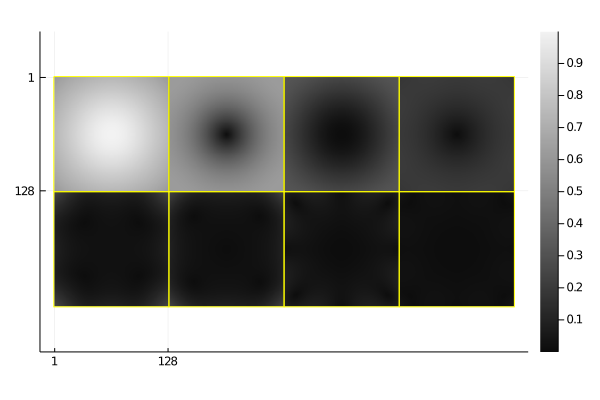

In [4]:
smap0,_,_ = ir_mri_coil_compress(b1c, ncoil=nc);
smap = smap0 ./ sqrt.(sum(abs2.(smap0), dims=3))
jim(smap, abswarn=false)

**Sampling mask**

Function `strucrand` is found in `helper_functions.jl`

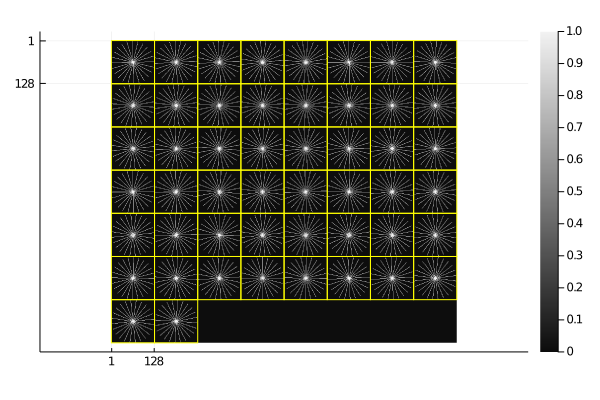

In [5]:
line = 12
samp = strucrand(nx, ny, nt, line)
pre_mask = fftshift(repeat(samp, 1, 1, 1, nc), 1:2)
mask = pre_mask .== 1
jim(samp)

**Acquisition operator and measured data**

In [6]:
E = getE(nx, ny, nt, nc, samp, smap, ComplexF64)

FunctionOperator with eltype Complex{Float64}
    Name: E
    Input dimensions: (128, 128, 50)
    Output dimensions: (128, 128, 50, 8)

Get components of acquisition operator separately:

In [7]:
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, smap, ComplexF64)

(FunctionOperator{Complex{Float64}}(Ω, (128, 128, 50, 8), (128, 128, 50, 8)), FunctionOperator{Complex{Float64}}(Q, (128, 128, 50, 8), (128, 128, 50, 8)), FunctionOperator{Complex{Float64}}(C, (128, 128, 50, 1), (128, 128, 50, 8)))

**Sparsifying transform**

A Fourier transform along the time dimension

In [8]:
T = getT(nx, ny, nt, ComplexF64)

FunctionOperator with eltype Complex{Float64}
    Name: T
    Input dimensions: (16384, 50)
    Output dimensions: (16384, 50)

**Decrease the rank of the data and add back some of the sparsity**

In [9]:
r = 15
F = svd(reshape(X_orig, nx*ny, nt))
orig_rank = sum(F.S .> 1e-8)
@show E_orig = sum(abs2, X_orig)
F.S[r+1:end] .= 0
X_low_rank = reshape(F.U * Diagonal(F.S) * F.Vt, nx, ny, nt)
@show E_low_rank = sum(abs2, X_low_rank);

E_orig = sum(abs2, X_orig) = 48424.68353848879
E_low_rank = sum(abs2, X_low_rank) = 48402.27560414426


E_sparse = sum(abs2, X_sparse) = 22.407934344665563
s = sum(abs2.(X_sparse) .> 0) = 54
E_sparse_trunc = sum(abs2, X_sparse) = 0.291596118044533


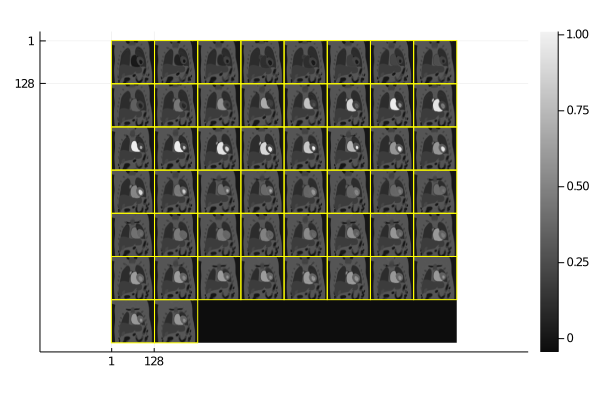

In [10]:
sparse_rel_thresh = 0.5

X_sparse = X_orig - X_low_rank
@show E_sparse = sum(abs2, X_sparse)

threshold = maximum(abs2, X_sparse) * sparse_rel_thresh
X_sparse[abs2.(X_sparse) .≤ threshold] .= 0
@show s = sum(abs2.(X_sparse) .> 0)
@show E_sparse_trunc = sum(abs2, X_sparse)

Xtrue = X_low_rank + X_sparse
ytrue = E * ComplexF64.(Xtrue)
jim(Xtrue)

**Add noise and prepare for regularization scaling**

Add complex noise such that the $SNR = 46dB$

In [11]:
noise = randn(Float32, size(ytrue)) + randn(Float32, size(ytrue))im # complex noise!
snr_dB = 46
scale_noise = norm(ytrue) / norm(noise) / 10^(snr_dB / 20.f0)
y = ytrue + scale_noise * noise
rms(x) = norm(x-ytrue) / sqrt(length(x-ytrue))
snr(x) = 20 * log10(norm(ytrue) / norm(x-ytrue))
@show rms(y)
@show snr(y);

rms(y) = 0.00041637366127187075
snr(y) = 45.9999991309447


## 4.2 Test algorithms

In [13]:
X_irls, cost_irls, rankL_irls, time_irls = HM_IRLS(Xtrue, y, E, maxIter = 3, N = 2, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.989,	σ₁ = 204.590,	ϵᵏ = Inf
k = 1,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 49.925,	σ₁ = 204.590,	ϵᵏ = 1.511
k = 2,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 29.471,	σ₁ = 205.077,	ϵᵏ = 1.511


Get scaling value required by all algorithms

In [56]:
x₀ = E' * y
St = svdvals(reshape(x₀ - E' * reshape(E * x₀ - y, nx, ny, nt, nc), nx*ny, nt));

**Run AL-CG**

In [57]:
X_cg, rankL_cg, cost_cg, time_cg = AL_CG(Xtrue, y, E, T, scale_L = maximum(St), scale_S = 1/1.887,
    δ₁ = 1//2, δ₂ = 1//2, N = 3, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.614
k = 1,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 32.041
k = 2,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 28.152
k = 3,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 25.444


**Run AL-2**

In [16]:
X_al, rankL_al, cost_al, time_al = AL_2(Xtrue, y, Ω, Q, C, T, scale_L = maximum(St), scale_S = 1/1.887,
    δ₁ = 1//3, δ₂ = 1//10, N = 3, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.989
k = 1,	rank(Xᵏ) = 3,	‖Xᴳᵀ - Xᵏ‖₂ = 59.875
k = 2,	rank(Xᵏ) = 3,	‖Xᴳᵀ - Xᵏ‖₂ = 45.634
k = 3,	rank(Xᵏ) = 5,	‖Xᴳᵀ - Xᵏ‖₂ = 37.719


**Run ISTA**

In [17]:
X_ista, rankL_ista, cost_ista, time_ista = PGM(Xtrue, y, E, T, scale_L = maximum(St), scale_S = 1/1.887,
    momentum = :ista, N = 3, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.989
k = 1,	rank(Xᵏ) = 28,	‖Xᴳᵀ - Xᵏ‖₂ = 37.946
k = 2,	rank(Xᵏ) = 20,	‖Xᴳᵀ - Xᵏ‖₂ = 32.478
k = 3,	rank(Xᵏ) = 17,	‖Xᴳᵀ - Xᵏ‖₂ = 28.928


**Run FISTA**

In [18]:
X_fista, rankL_fista, cost_fista, time_fista = PGM(Xtrue, y, E, T, scale_L = maximum(St), scale_S = 1/1.887,
    momentum = :fista, N = 3, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.989
k = 1,	rank(Xᵏ) = 28,	‖Xᴳᵀ - Xᵏ‖₂ = 42.481
k = 2,	rank(Xᵏ) = 16,	‖Xᴳᵀ - Xᵏ‖₂ = 38.227
k = 3,	rank(Xᵏ) = 12,	‖Xᴳᵀ - Xᵏ‖₂ = 35.019


**Run POGM**

In [19]:
X_pogm, rankL_pogm, cost_pogm, time_pogm = PGM(Xtrue, y, E, T, scale_L = maximum(St), scale_S = 1/1.887,
    momentum = :pogm, N = 3, verbose = true);

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 47.989
k = 1,	rank(Xᵏ) = 28,	‖Xᴳᵀ - Xᵏ‖₂ = 39.494
k = 2,	rank(Xᵏ) = 20,	‖Xᴳᵀ - Xᵏ‖₂ = 32.167
k = 3,	rank(Xᵏ) = 16,	‖Xᴳᵀ - Xᵏ‖₂ = 28.181


In [191]:
X_mslr, cost_mslr, time_mslr =
    MultiScaleLowRank(Xtrue, y, samp, λ = 1e-4, ComplexF64.(smap), max_epoch=20, max_power_iter=1);

 ---- Initialization ----
initialization:				  0.058836 seconds (178.97 k allocations: 10.055 MiB)
power iterations:			  1.089666 seconds (77.58 k allocations: 910.080 MiB, 2.00% gc time)
 ---- Reconstruction ----


MSLR 100%|██████████████████████████████████████████████| Time: 0:00:16


### Save results

In [24]:
fname = "results/line_$(line)_rank_$(r)_sparsity_$(sparse_rel_thresh)_SNR_$(snr_dB).jld"
@save(fname, line, r, sparse_rel_thresh, snr_dB, E_orig, E_low_rank, E_sparse, s, E_sparse_trunc,
    X_irls, cost_irls, rankL_irls, time_irls,
    X_cg, rankL_cg, cost_cg, time_cg,
    X_al, rankL_al, cost_al, time_al,
    X_ista, rankL_ista, cost_ista, time_ista,
    X_fista, rankL_fista, cost_fista, time_fista,
    X_pogm, rankL_pogm, cost_pogm, time_pogm,
    X_mslr, cost_mslr, time_mslr)

**Compare algorithms**

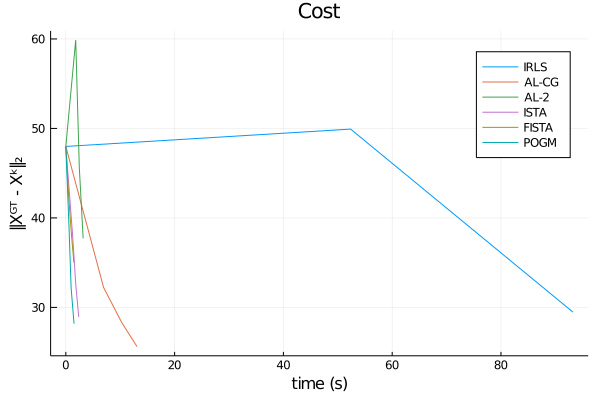

In [25]:
plot(time_irls, cost_irls, label="IRLS", title = "Cost", xlabel = "time (s)", ylabel = "‖Xᴳᵀ - Xᵏ‖₂")
plot!(time_cg, cost_cg, label="AL-CG")
plot!(time_al, cost_al, label="AL-2")
plot!(time_ista, cost_ista, label="ISTA")
plot!(time_fista, cost_fista, label="FISTA")
plot!(time_pogm, cost_pogm, label="POGM")

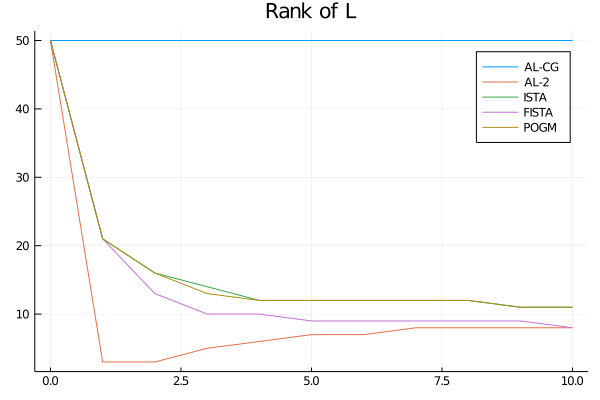

In [39]:
plot(0:10, collect(rankL_cg), label="AL-CG", title = "Rank of L")
plot!(0:10, collect(rankL_al), label="AL-2")
plot!(0:10, collect(rankL_ista), label="ISTA")
plot!(0:10, collect(rankL_fista), label="FISTA")
plot!(0:10, collect(rankL_pogm), label="POGM")